# **Prepare Dataset**

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'suchintikasarkar/sentiment-analysis-for-mental-health'

Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
 90% 10.0M/11.1M [00:01<00:00, 12.5MB/s]
100% 11.1M/11.1M [00:01<00:00, 10.9MB/s]


In [ ]:
import zipfile

dataset_zip = zipfile.ZipFile('/content/sentiment-analysis-for-mental-health.zip', 'r')
dataset_zip.extractall()
dataset_zip.close()

# **Read and Define Data to Variable**

In [ ]:
import pandas as pd
raw_data = pd.read_csv('/content/Combined Data.csv')

# Local computing
# raw_data = pd.read_csv('../data/sentiments.csv')

In [ ]:
raw_data.shape

(53043, 3)

In [ ]:
df = raw_data.dropna()
print('Total data (rows):', len(df), '\n')

df.sample(frac = 1).head()

Total data (rows): 52681 



,Unnamed: 0,statement,status
31309,31309,mostly talk radio.,Normal
20730,20730,Hello guys this is my first time making a post...,Depression
51875,51875,need help with SSRI nausea I was wondering if...,Anxiety
31018,31018,what are they?,Normal
51374,51374,Liking someone I wanna know how other people w...,Personality disorder


In [ ]:
# Count the number of occurrences of each class

class_counts = df['status'].value_counts()
class_counts

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [ ]:
# Remove imbalance label data

df = df[~df['status'].isin(('Anxiety', 'Bipolar', 'Stress', 'Personality disorder'))]
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652


# **Label Encoding**

In [ ]:
classes = df['status'].unique()
print('Total classes/ labels:', len(classes), '\n')
classes

Total classes/ labels: 3 



array(['Normal', 'Depression', 'Suicidal'], dtype=object)

In [ ]:
import numpy as np
import pandas as pd

def to_class_num(class_name):
    class_list_num = np.where(classes == class_name)[0][0]
    return class_list_num

def to_class_name(class_num):
    return classes[class_num]

classes_pd = pd.DataFrame({
    'Class Name' : classes,
    'Value' : [to_class_num(class_name) for class_name in classes]
})
display(classes_pd)

,Class Name,Value
0,Normal,0
1,Depression,1
2,Suicidal,2


# **Train-Test Split & Preprocessing Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

x_data = df['statement']
y_data = df['status']

x_train, x_test, y_train, y_test = train_test_split(
    x_data.values,
    y_data.values,
    test_size = 0.3,
    random_state = 1000
)
print(len(x_train), len(y_train), len(x_test), len(y_test))

29679 29679 12720 12720


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='UNK', lower = True)
tokenizer.fit_on_texts(x_data.values)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_test_tokenized = tokenizer.texts_to_sequences(x_test)

In [ ]:
max_len = max([len(x) for x in x_train_tokenized])
print(max_len)

6300


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_tokenized_padded = pad_sequences(x_train_tokenized, maxlen = max_len)
x_test_tokenized_padded = pad_sequences(x_test_tokenized, maxlen = max_len)

x_train_tokenized_padded[0]

array([  0,   0,   0, ...,   3,   6, 536], dtype=int32)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

54741

# **Defining Device and Transforming Dataset**

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print('Device:', device, '\n')

Device: cuda:0 



In [ ]:
from torch.utils.data import Dataset

class CustomizedDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = torch.from_numpy(self.x[idx])
        y = torch.tensor(to_class_num(self.y[idx]))
        return x, y

sample = CustomizedDataset(x_train_tokenized_padded, y_train)
sample[0]

(tensor([  0,   0,   0,  ...,   3,   6, 536], dtype=torch.int32), tensor(1))

# **Batch Data Loading**

In [ ]:
from torch.utils.data import DataLoader

batch_size = 24
train_dataloader = DataLoader(CustomizedDataset(x_train_tokenized_padded, y_train), shuffle = True, batch_size = batch_size)
test_dataloader = DataLoader(CustomizedDataset(x_test_tokenized_padded, y_test), shuffle = True, batch_size = batch_size)

train_dataloader

# **Define & Build Model**

In [ ]:
import torch.nn as nn

num_lstm = 1
num_hidden = 32
embedding_size = 128

softmax = nn.Softmax(dim=1)

class SentimentAnalysisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embd = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.lstm = nn.LSTM(embedding_size, num_hidden, bidirectional = True, num_layers=num_lstm)
        self.linear = nn.Linear(2 * num_hidden * max_len, len(classes))
        self.dropout = nn.Dropout(p=0.35)

    def forward(self, x):
        logits = self.embd(x)
        logits , (h_n, c_n) = self.lstm(logits)
        logits = logits.flatten(start_dim = 1, end_dim=-1)
        logits = self.linear(logits)
        logits = self.dropout(logits)
        probability = softmax(logits)
        return logits, probability

In [ ]:
model = SentimentAnalysisModel()
model.train()

SentimentAnalysisModel(
  (embd): Embedding(54741, 128, padding_idx=0)
  (lstm): LSTM(128, 32, bidirectional=True)
  (linear): Linear(in_features=403200, out_features=3, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [ ]:
test = x_train_tokenized_padded[0]
test = torch.from_numpy(test[None, :])
print(test.shape)
pred, prob = model(test)
print(pred.shape)

torch.Size([1, 6300])
torch.Size([1, 3])


In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn

# # Convert class weight to tensor
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Use with CrossEntropyLoss
# cross_entropy = nn.CrossEntropyLoss(weight=class_weights_tensor)

cross_entropy = nn.CrossEntropyLoss()   # criterion
model = model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.02, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
epochs = 24

avg_loss = []
avg_acc = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    acc = 0
    loss_acc = 0
    n = 0

    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)

        pred, prob = model(x)

        loss = cross_entropy(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = pred.argmax(axis=1)

        acc += (output == y).sum().item()
        n += y.shape[0]
        loss_acc += loss.item()

    avg_loss.append(loss_acc / len(train_dataloader))
    avg_acc.append(acc / n)
    print('Average Loss    :', loss_acc / len(train_dataloader))
    print('Average Accuracy:', acc / n)

    # scheduler.step()

Epoch 1/24


100%|██████████| 1414/1414 [00:32<00:00, 43.10it/s]


Average Loss    : 2.531576058989367
Average Accuracy: 0.6153778118458682
Epoch 2/24


100%|██████████| 1414/1414 [00:32<00:00, 43.09it/s]


Average Loss    : 0.6818965316514315
Average Accuracy: 0.7108110498540641
Epoch 3/24


100%|██████████| 1414/1414 [00:34<00:00, 41.51it/s]


Average Loss    : 0.5871939185527292
Average Accuracy: 0.7485480114390165
Epoch 4/24


100%|██████████| 1414/1414 [00:34<00:00, 41.25it/s]


Average Loss    : 0.5369770395684107
Average Accuracy: 0.7681240602612105
Epoch 5/24


100%|██████████| 1414/1414 [00:33<00:00, 42.47it/s]


Average Loss    : 0.514595871303847
Average Accuracy: 0.7802411627701288
Epoch 6/24


100%|██████████| 1414/1414 [00:33<00:00, 42.41it/s]


Average Loss    : 0.48674260742719977
Average Accuracy: 0.7911495032282791
Epoch 7/24


100%|██████████| 1414/1414 [00:33<00:00, 42.16it/s]


Average Loss    : 0.46957371064594816
Average Accuracy: 0.7967805654647837
Epoch 8/24


100%|██████████| 1414/1414 [00:33<00:00, 42.56it/s]


Average Loss    : 0.454322927732869
Average Accuracy: 0.8056841298387335
Epoch 9/24


100%|██████████| 1414/1414 [00:33<00:00, 42.45it/s]


Average Loss    : 0.4406273156046193
Average Accuracy: 0.8104012500368525
Epoch 10/24


100%|██████████| 1414/1414 [00:33<00:00, 42.37it/s]


Average Loss    : 0.4250217808839961
Average Accuracy: 0.8180370883575577
Epoch 11/24


100%|██████████| 1414/1414 [00:33<00:00, 42.30it/s]


Average Loss    : 0.4211381995652656
Average Accuracy: 0.8183024263687019
Epoch 12/24


100%|██████████| 1414/1414 [00:33<00:00, 42.22it/s]


Average Loss    : 0.4094692080675544
Average Accuracy: 0.8240219346089213
Epoch 13/24


100%|██████████| 1414/1414 [00:33<00:00, 42.29it/s]


Average Loss    : 0.40348006494058747
Average Accuracy: 0.8246115746336862
Epoch 14/24


100%|██████████| 1414/1414 [00:33<00:00, 42.35it/s]


Average Loss    : 0.3922074881120146
Average Accuracy: 0.8283557887909432
Epoch 15/24


100%|██████████| 1414/1414 [00:33<00:00, 42.31it/s]


Average Loss    : 0.3863726000142148
Average Accuracy: 0.832453786963059
Epoch 16/24


100%|██████████| 1414/1414 [00:33<00:00, 42.44it/s]


Average Loss    : 0.3847819131600132
Average Accuracy: 0.8335151390076359
Epoch 17/24


100%|██████████| 1414/1414 [00:33<00:00, 42.23it/s]


Average Loss    : 0.3756476451486054
Average Accuracy: 0.8377310651847047
Epoch 18/24


100%|██████████| 1414/1414 [00:33<00:00, 42.41it/s]


Average Loss    : 0.36867246614529353
Average Accuracy: 0.8388513812317581
Epoch 19/24


100%|██████████| 1414/1414 [00:33<00:00, 42.28it/s]


Average Loss    : 0.3661265612291396
Average Accuracy: 0.8412099413308175
Epoch 20/24


100%|██████████| 1414/1414 [00:33<00:00, 42.40it/s]


Average Loss    : 0.3604172097605981
Average Accuracy: 0.8435095374274005
Epoch 21/24


100%|██████████| 1414/1414 [00:33<00:00, 42.15it/s]


Average Loss    : 0.35606782557772104
Average Accuracy: 0.8442465874583567
Epoch 22/24


100%|██████████| 1414/1414 [00:33<00:00, 42.46it/s]


Average Loss    : 0.3470101969519464
Average Accuracy: 0.8486099236416168
Epoch 23/24


100%|██████████| 1414/1414 [00:33<00:00, 42.25it/s]


Average Loss    : 0.3452199346358233
Average Accuracy: 0.8507031457295321
Epoch 24/24


100%|██████████| 1414/1414 [00:33<00:00, 42.46it/s]

Average Loss    : 0.34010972829780617
Average Accuracy: 0.8523541377988738


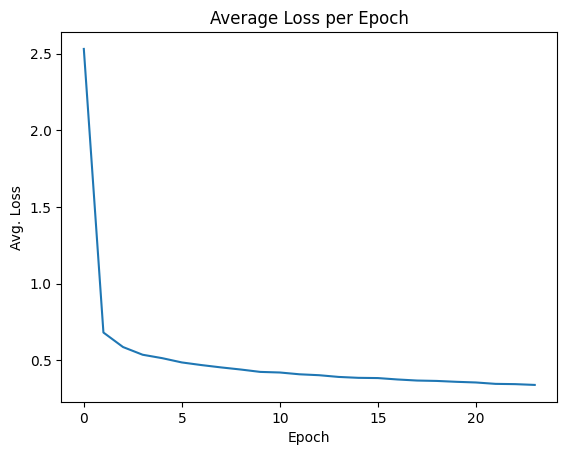

In [ ]:
from matplotlib import pyplot as plt

plt.plot(range(len(avg_loss)), avg_loss)
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss')
plt.show()

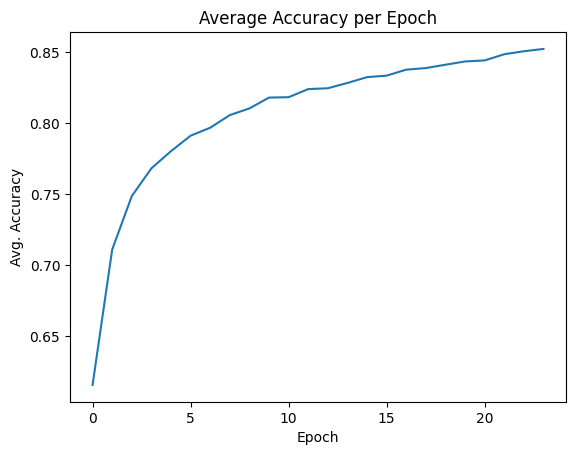

In [ ]:
plt.plot(range(len(avg_acc)), avg_acc)
plt.title('Average Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Avg. Accuracy')
plt.show()

In [ ]:
model.eval()

SentimentAnalysisModel(
  (embd): Embedding(54741, 128, padding_idx=0)
  (lstm): LSTM(128, 32, bidirectional=True)
  (linear): Linear(in_features=403200, out_features=3, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)

In [ ]:
n = 0
acc = 0

y_test = []
y_pred = []

for x, y in tqdm(test_dataloader):
    pred, prob = model(x.to(device))
    output = pred.argmax(axis = 1)
    n += y.shape[0]
    acc += (output == y.to(device)).sum().item()
    y_test.extend(y.cpu().numpy())
    y_pred.extend(output.cpu().numpy())
    
print()
print('Average test accuracy:', acc / n)

100%|██████████| 354/354 [00:03<00:00, 101.23it/s]


Average test accuracy: 0.8050707547169811


# **Model Evaluation**

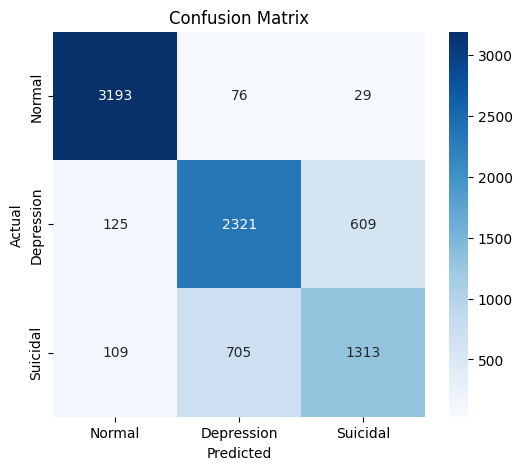

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

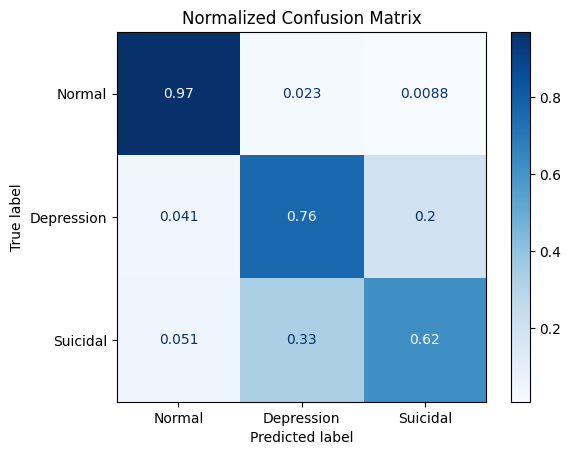

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes, cmap='Blues', normalize='true')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn import metrics

pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names = classes, output_dict=True))

,Normal,Depression,Suicidal,accuracy,macro avg,weighted avg
precision,0.931719,0.748227,0.672988,0.805071,0.784311,0.800718
recall,0.968163,0.759738,0.617301,0.805071,0.781734,0.805071
f1-score,0.949591,0.753939,0.643943,0.805071,0.782491,0.802441
support,3298.000000,3055.000000,2127.000000,0.805071,8480.000000,8480.000000


In [ ]:
# Save entire model

PATH = '/content/sentiment_analysis_model.h5'
torch.save(model, PATH)

In [ ]:
# Save configuration file

import json

# Create a dictionary to store all the variables
data = {
    'classes': classes.tolist(),
    'max_len': max_len,
    'vocab_size': vocab_size,
    'tokenizer': tokenizer.to_json()
}

# Save the dictionary to a pickle file
with open('config.json', 'w') as f:
    json.dump(data, f)

# **Predicting**

In [ ]:
def predict_sentiment(text):
    input_tensor = torch.from_numpy(pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = max_len))
    pred, prob = model(input_tensor.to(device))
    pred = pred.cpu().detach().numpy().argmax(axis=1).flatten()[0]
    return to_class_name(pred), prob.max().item()

In [ ]:
predict_sentiment(input("What's your matter?\n"))

What's your matter?
I feel very stressed from a few days everyone hates me I have not been happy from over a month


('Depression', 0.6082115173339844)

In [ ]:
# im hopeless, need someone here before i kill myself
# I feel very stressed from a few days everyone hates me I have not been happy from over a month
# this is the happiest day of my life, my life is going to be perfect  // 1 by 1: normal, both: suicide, depression??